In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
import datetime

In [2]:
# 1d brownian motion (weiner process)
def brownian_motion(T, N):
    dt = T/N
    W = np.zeros(N)
    
    for i in range(1, N):
        W[i] = W[i-1] + np.random.normal()*np.sqrt(dt)
    
    return W

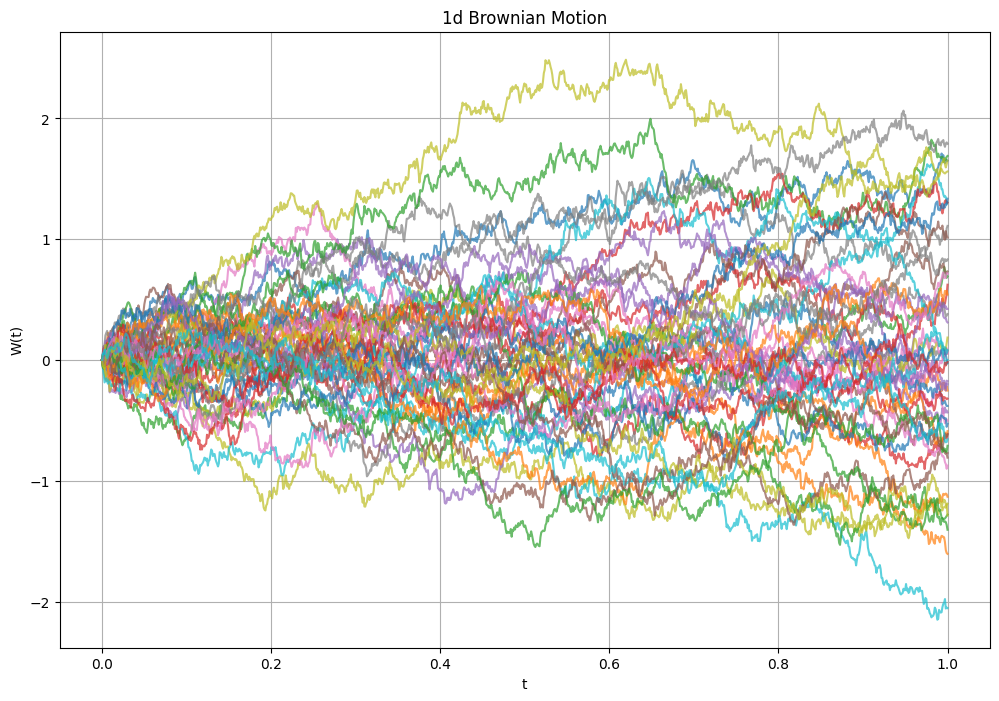

In [3]:
# simulate 100 brownian motions
t = np.linspace(0, 1, 1000)
plt.figure(figsize=(12, 8))
for i in range(50):
    plt.plot(t, brownian_motion(1, 1000), alpha=0.7)
    
plt.xlabel('t')
plt.ylabel('W(t)')
plt.title('1d Brownian Motion')
plt.grid()
plt.show()

In [4]:
def gbm(s_0, mu, sigma, T, N):
    s = np.zeros(N)
    W = brownian_motion(T, N)
    
    for i in range(N):
        s[i] = s_0*np.exp((mu - sigma**2/2)*i/N + sigma*W[i])
    
    return s

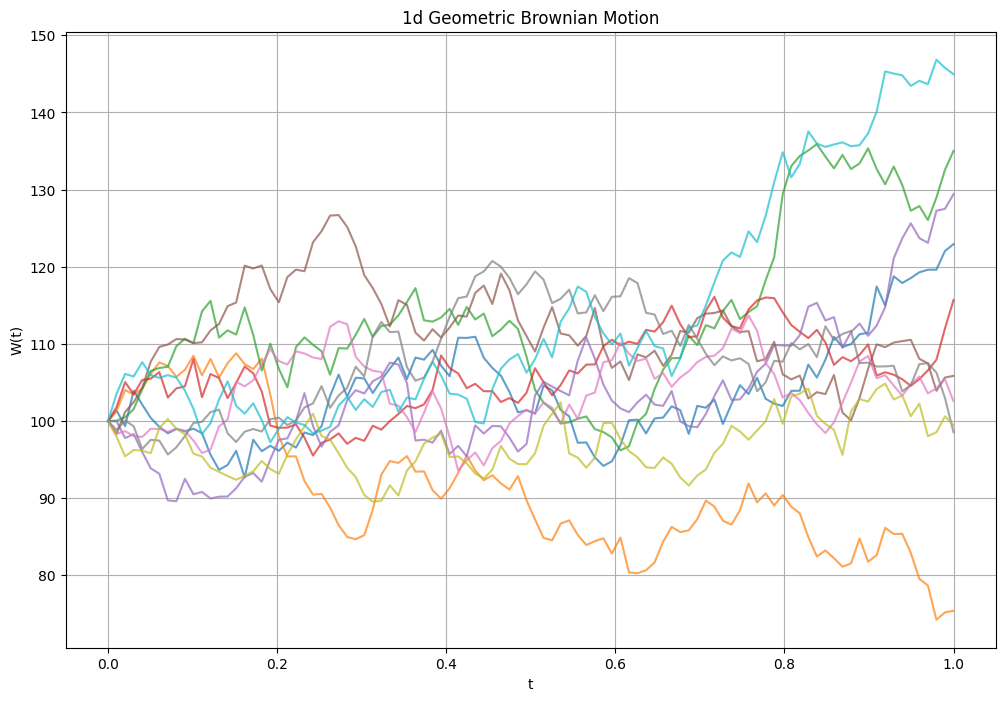

In [5]:
# simulate 100 geometric brownian motions
n = 100 # number of time steps
t = np.linspace(0, 1, n)
s_0 = 100 # initial stock price
mu = 0.1 # expected return (drift)
sigma = 0.2 # volatility (diffusion)

plt.figure(figsize=(12, 8))
for i in range(10):
    plt.plot(t, gbm(s_0, mu, sigma, 1, n), alpha=0.7)
    
plt.xlabel('t')
plt.ylabel('W(t)')
plt.title(
    '1d Geometric Brownian Motion'
)
plt.grid()
plt.show()

In [6]:
# black-scholes
def black_scholes_call(s_0, k, t, r, sigma):
    d_1 = (np.log(s_0/k) + (r + sigma**2/2)*t)/(sigma*np.sqrt(t))
    d_2 = d_1 - sigma*np.sqrt(t)
    c = norm.cdf(d_1)*s_0 - norm.cdf(d_2)*k*np.exp(-r*t)

    return c

In [7]:
black_scholes_call(
    100,
    90,
    0.25,
    0.1,
    0.4
)

15.116766024697668

In [8]:
# sensitivity analysis
# base parameters
s0 = 100
t = 0.25 # expires in 1 quarter
r = 0.04
sigma = 0.2
k = 95

In [9]:
# vary stock price s_0
d_s0 = np.linspace(s0*0.5, s0*1.5, 100)
c_s0 = [black_scholes_call(x, k, t, r, sigma) for x in d_s0]

# vary strike price k
d_k = np.linspace(k*0.5, k*1.5, 100)
c_k = [black_scholes_call(s0, x, t, r, sigma) for x in d_k]

# vary time to expiration t
d_t = np.linspace(0.001, 1, 100)
c_t = [black_scholes_call(s0, k, x, r, sigma) for x in d_t]

# vary risk-free rate r
d_r = np.linspace(0.001, 0.1, 100)
c_r = [black_scholes_call(s0, k, t, x, sigma) for x in d_r]

# vary volatility sigma
d_sigma = np.linspace(0.001, 0.5, 100)
c_sigma = [black_scholes_call(s0, k, t, r, x) for x in d_sigma]

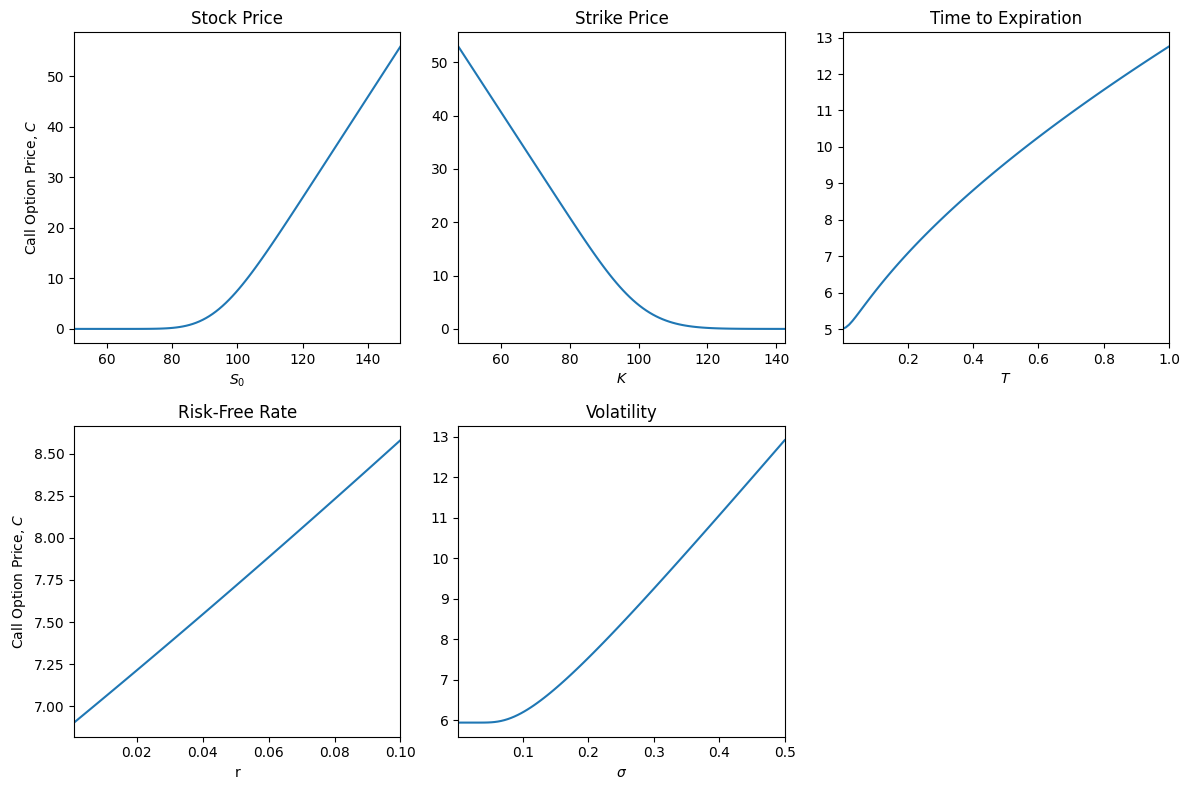

In [10]:
# plot
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].set_ylabel(rf'Call Option Price, $C$')
ax[0, 0].plot(d_s0, c_s0)
ax[0, 0].set_title('Stock Price')
ax[0, 0].set_xlabel(rf'$S_0$')
ax[0, 0].set_xlim([np.min(d_s0), np.max(d_s0)])

ax[0, 1].plot(d_k, c_k)
ax[0, 1].set_title('Strike Price')
ax[0, 1].set_xlabel('$K$')
ax[0, 1].set_xlim([np.min(d_k), np.max(d_k)])

ax[0, 2].plot(d_t, c_t)
ax[0, 2].set_title('Time to Expiration')
ax[0, 2].set_xlabel(rf'$T$')
ax[0, 2].set_xlim([np.min(d_t), np.max(d_t)])

ax[1, 0].set_ylabel(rf'Call Option Price, $C$')
ax[1, 0].plot(d_r, c_r)
ax[1, 0].set_title('Risk-Free Rate')
ax[1, 0].set_xlabel(rf'r')
ax[1, 0].set_xlim([np.min(d_r), np.max(d_r)])

ax[1, 1].plot(d_sigma, c_sigma)
ax[1, 1].set_title('Volatility')
ax[1, 1].set_xlabel(rf'$\sigma$')
ax[1, 1].set_xlim([np.min(d_sigma), np.max(d_sigma)])

fig.delaxes(ax[1, 2])

plt.tight_layout()
plt.show()

In [11]:
# options data
TICKER = 'NVDA'
ticker = yf.Ticker(TICKER)
expire_date = ticker.options[6]
option_data = ticker.option_chain(expire_date).calls
option_data['expireDate'] = expire_date
option_data = option_data[option_data['strike'] == 130]

# historical price data
date = datetime.datetime.today()
end_date = date.strftime('%Y-%m-%d')
start_date = (date - datetime.timedelta(days=365)).strftime('%Y-%m-%d')
price_data = yf.download(TICKER, start=start_date, end=end_date)['Adj Close']

# risk free rate
rf = yf.Ticker('^TNX').info['previousClose']/100

[*********************100%%**********************]  1 of 1 completed


In [12]:
option_data

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expireDate
168,NVDA241220C00130000,2024-10-18 19:59:55+00:00,130.0,17.07,17.0,17.15,0.27,1.607146,2969.0,120361.0,0.581486,True,REGULAR,USD,2024-12-20


In [13]:
# calculating options price using black-scholes
strike_price = option_data['strike'].values[0]
days_till_exp = len(pd.bdate_range(
    start=date,
    end=option_data['expireDate'].values[0]
))
calculated_sigma = price_data.pct_change().dropna().std()*np.sqrt(252)
stock_price = price_data.iloc[-1]

calculated_price = black_scholes_call(
    stock_price,
    strike_price,
    days_till_exp/252,
    rf,
    calculated_sigma
)

In [14]:
print(f'Calculated price of CALL Option based on Black-Scholes: ${calculated_price.round(2)}')
print(f'Actual price of CALL Option: ${option_data["lastPrice"].values[0]}')

Calculated price of CALL Option based on Black-Scholes: $16.68
Actual price of CALL Option: $17.07


In [15]:
# implied volatility
def implied_volatility(s0, k, t, r, actual_price):
    # optimize objective function to equal 0
    objective_function = lambda x: black_scholes_call(s0, k, t, r, x) - actual_price

    # root finding
    return brentq(objective_function, 0.0001, 1)

In [16]:
actual_price = option_data['lastPrice'].values[0]
implied_vol = implied_volatility(
    stock_price,
    strike_price,
    days_till_exp/252,
    rf,
    actual_price
)
actual_implied_vol = option_data['impliedVolatility'].values[0]

print(f'Calculated Volatility: {calculated_sigma}')
print(f'Calculated Implied Volatility: {implied_vol}')
print(f'Given Implied Volatility: {actual_implied_vol}')

Calculated Volatility: 0.519240083388801
Calculated Implied Volatility: 0.5376592666588509
Given Implied Volatility: 0.581486118774414


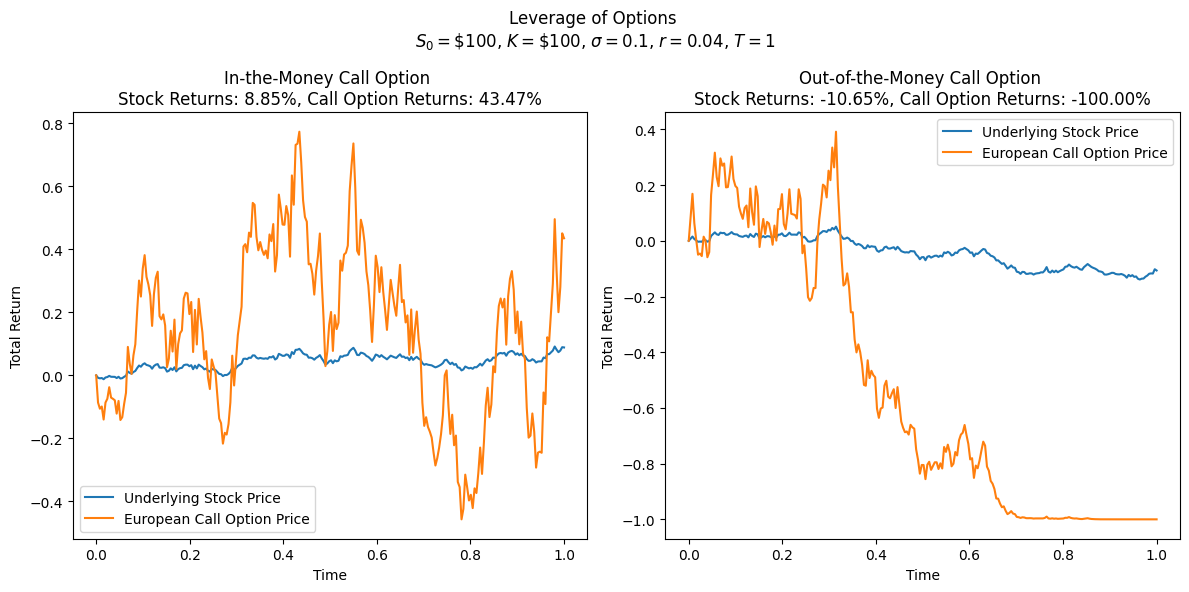

In [34]:
# visualize leverage
n = 252 # number of time steps
t = np.linspace(0, 1, n)
s_0 = 100 # initial stock price
mu_1 = 0.05 # expected return (drift)
sigma = 0.1 # volatility (diffusion)
rf = 0.04
k = 100
mu_2 = -0.05

stock_prices_1 = gbm(s_0, mu_1, sigma, 1, n)
stock_prices_2 = gbm(s_0, mu_2, sigma, 1, n)
stock_returns_1 = (stock_prices_1 - stock_prices_1[0]) / stock_prices_1[0]
stock_returns_2 = (stock_prices_2 - stock_prices_2[0]) / stock_prices_2[0]

itm_call = [black_scholes_call(x, k, 1-i*1/n, rf, sigma) for i, x in enumerate(stock_prices_1)]
otm_call = [black_scholes_call(x, k, 1-i*1/n, rf, sigma) for i, x in enumerate(stock_prices_2)]
itm_returns = (itm_call - itm_call[0]) / itm_call[0]
otm_returns = (otm_call - otm_call[0]) / otm_call[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(t, stock_returns_1, label='Underlying Stock Price')
ax[0].plot(t, itm_returns, label='European Call Option Price')
ax[0].set_title(
    'In-the-Money Call Option \n'
    f'Stock Returns: {100*stock_returns_1[-1]:.2f}%, Call Option Returns: {100*itm_returns[-1]:.2f}%'
)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Total Return')
ax[0].legend()

ax[1].plot(t, stock_returns_2, label='Underlying Stock Price')
ax[1].plot(t, otm_returns, label='European Call Option Price')
ax[1].set_title(
    'Out-of-the-Money Call Option \n'
    f'Stock Returns: {100*stock_returns_2[-1]:.2f}%, Call Option Returns: {100*otm_returns[-1]:.2f}%'
)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Total Return')
ax[1].legend()

fig.suptitle(
    'Leverage of Options \n'
    rf'$S_0 = \${s_0}$, $K = \${k}$, $\sigma = {sigma}$, $r = {rf}$, $T = 1$'
)

plt.tight_layout()
plt.show()

In [ ]:
# visualize hedging
